# Imports, variables, functions

In [1]:
# -- IMPORTS --

import scipy.io
from pyedflib import highlevel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
import csv
import pickle
from scipy.signal import butter, sosfilt, sosfiltfilt, sosfreqz
from scipy.signal import freqz, iirnotch, filtfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy import signal

In [2]:
# -- ENVIRONMENT VARIABLES --

sample_rate = sampling_rate = 256
sec = 10
len_window = sample_rate*sec
overlap = 5
threshold = 2*sample_rate
sample_rate_downsample = int(0.1*sample_rate)
len_window_downsample = sample_rate_downsample*sec

patients = list(range(1, 80))
patient_with_issue = [4, 29, 50] 
for i in patient_with_issue:
    patients.remove(i)

# Load annotation file
annt = scipy.io.loadmat('../raw_data/annotations_2017.mat')

In [3]:
## -- PREPROCESSING FUNCTIONS --

# Highpass filter
def highpass_filter(signals, sampling_rate, hp_frequency = 0.1):
    sos = butter(N = 3, Wn = hp_frequency, btype="highpass",fs=sampling_rate, output="sos")
    filter_hp = sosfiltfilt(sos, signals)
    return filter_hp

# Powerline filter
def notch_filter(signals, sampling_rate, notch_frequency = 50, quality_factor = 30):
    w0 = notch_frequency/(sampling_rate/2)
    b_notch, a_notch = iirnotch(w0, quality_factor)
    filter_notch = filtfilt(b_notch, a_notch, signals, axis = -1)
    return filter_notch

# Create our own scaler
class CustomTranformer(TransformerMixin, BaseEstimator): 
    # BaseEstimator generates the get_params() and set_params() methods that all Pipelines require
    # TransformerMixin creates the fit_transform() method from fit() and transform()
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.means = X.mean()
        return self
    
    def transform(self, X, y=None):
        norm_features = X - self.means
        return norm_features

# Combination of all filters and Scaler
def filter_signals(signals, sampling_rate, scaler, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30):
    filter_hp = highpass_filter(signals, sampling_rate)
    filter_notch = notch_filter(filter_hp, sampling_rate, notch_frequency, quality_factor)
    final_signal = scaler.fit_transform(filter_notch)
    return final_signal

In [4]:
## -- LABEL FUNCTIONS --

# Format the EEG 
def eeg_formated(signals, names_ele):
    data_signals = signals.T # transpose the signals from datapoints
    data_signals = pd.DataFrame(data_signals) # create a pandas dataframe
    
    data_signals.columns = names_ele # rename columns
    
    return data_signals

# Format the annotations
def diagnosis(n):
    patient_A=annt["annotat_new"][0][n-1][0]
    patient_B=annt["annotat_new"][0][n-1][1]
    patient_C=annt["annotat_new"][0][n-1][2]
    
    #converting seconds to datapoints

    patient_A=patient_A.tolist()
    patient_B=patient_B.tolist()
    patient_C=patient_C.tolist()
    
    patient_A_dtp=[]
    patient_B_dtp=[]
    patient_C_dtp=[]  
    for elem in patient_A:
        for i in range(sampling_rate):
            patient_A_dtp.append(elem) 
    for elem in patient_B:
        for i in range(sampling_rate):
            patient_B_dtp.append(elem)
        
    for elem in patient_C:
        for i in range(sampling_rate):
            patient_C_dtp.append(elem)
            
    target_=pd.DataFrame({"Diagnosis A":patient_A_dtp,"Diagnosis B":patient_B_dtp,"Diagnosis C":patient_C_dtp})
    
    return target_  

# Create target variables when seizures lasts at least 10
def is_seizure(df):
    
    threshold = sampling_rate*10
    
    df['is_seizure_A'] = df["Diagnosis A"].groupby((df["Diagnosis A"] != df["Diagnosis A"].shift()).cumsum()).transform('size') * df["Diagnosis A"]
    df['is_seizure_A'] = (df['is_seizure_A'] > threshold).astype(int)
    
    df['is_seizure_B'] = df["Diagnosis B"].groupby((df["Diagnosis B"] != df["Diagnosis B"].shift()).cumsum()).transform('size') * df["Diagnosis B"]
    df['is_seizure_B'] = (df['is_seizure_B'] > threshold).astype(int)
    
    df['is_seizure_C'] = df["Diagnosis C"].groupby((df["Diagnosis C"] != df["Diagnosis C"].shift()).cumsum()).transform('size') * df["Diagnosis C"]
    df['is_seizure_C'] = (df['is_seizure_C'] > threshold).astype(int)
    
    return df 

# Create final target
def create_target(df):
    df['is_seizure_target'] = np.where(df['is_seizure_A'] + df['is_seizure_B'] + df['is_seizure_C'] >= 2, 1, 0)
    return df

# Remove useless
def remove_useless_columns(df):
    df.drop(columns=['Diagnosis A', 'Diagnosis B', 'Diagnosis C', 'is_seizure_A', 'is_seizure_B', 'is_seizure_C', 'ECG EKG', 'Resp Effort'], inplace=True)
    return df

# Final function to label
def label_data(path_raw_data, signals_preprocessed, n):
    
    signals, signal_headers, header = highlevel.read_edf(path_raw_data)
    
    names_ele = [signal_headers[iele]['label'] for iele in range(signals.shape[0])] # extract electrode names
    
    eeg_patient = eeg_formated(signals_preprocessed, names_ele) # format the ECG
    eeg_patient.rename(columns={'ECG EKG-REF':'ECG EKG', 'Resp Effort-REF':'Resp Effort'}, inplace=True)
    
    diagnosis_patient = diagnosis(n) # format the diagnosis
    
    data_patient = pd.merge(left=eeg_patient, right=diagnosis_patient, how='left', left_index=True, right_index=True) # merge ecg and diagnosis
    
    is_seizure(data_patient)
    create_target(data_patient)
    remove_useless_columns(data_patient)
    
    return data_patient

In [5]:
## -- FEATURE ENGINEERING --

def flatten(window_df):
    if len(np.unique(window_df.iloc[:,-1])) == 1:
        target = window_df.iloc[0,-1]
    elif np.unique(window_df.iloc[:,-1],return_counts=True)[1][1] >= threshold:
        target = 1
    else:
        target = 0
    t_df = window_df.drop(columns = "target").transpose()
    flatten = pd.DataFrame(np.array(t_df).reshape(1,t_df.shape[0]*t_df.shape[1]))
    flatten["Target"] = target
    return flatten

In [6]:
## -- MAIN FUNCTIONS --

def preprocess_and_label(path_raw_data, scaler, patient_number, Fournier=False):
    
    # Load raw data
    signals, signal_headers, header = highlevel.read_edf(path_raw_data)
    
    # Preprocess data 
    signals_preprocessed = filter_signals(signals, sampling_rate, scaler, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30)
    
    if Fournier == True:
        signals_preprocessed = pd.DataFrame(np.array([abs(rfft(signals_preprocessed[i])) for i in range(len(signals_preprocessed))]))
        
    # Label data
    df = label_data(path_raw_data, signals_preprocessed, patient_number)
    
    return df

def downsampling(df):
    df_downsample = pd.DataFrame()
    all_df = pd.DataFrame()
    target_col = df.iloc[:,-1]
    num = int(0.1*sample_rate)
    t = 256
    for i, column in enumerate(df.columns[:-1]):
        df_downsample = pd.DataFrame()
        for j in range(0,len(df)-sample_rate,sample_rate):
            x = np.array(df.iloc[j:j+sample_rate,i])
            x_resampled = pd.DataFrame(signal.resample(x, num), index=range(int(j/10),int(j/10)+num))
            df_downsample= pd.concat([df_downsample,x_resampled])
        all_df[column] = np.array(df_downsample).reshape(1,-1)[0]
    target = []
    for t in range(0,len(target_col)-256,sample_rate):
        for n in range(num):
            target.append(target_col[t])
    all_df["target"] = target
    return all_df

def flatten_dataframe(df):
    data = np.array([flatten(df.iloc[i:i+len_window_downsample]) for i in range(0,len(df)-len_window_downsample, overlap*sample_rate_downsample)])
    r=data.shape[0]
    c=data.shape[2]
    data = pd.DataFrame(data.reshape(r,c))
    return data

def concat_dataframes(dictionnary_of_dataframes):
    df = pd.concat([dictionnary_of_dataframes[i] for i in dictionnary_of_dataframes.keys()])
    return df

def create_x_and_y(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X,y

def oversampling(X, y): 
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    X, y = sm.fit_resample(X, y)
    return X, y

# EEGs of unhealthy patients and Pipeline

In [14]:
patients = list(range(1, 80))

patient_with_issue = [4, 29, 50] # Can't import ECG4, ECG29 and ECG50
patient_without_seizure = [2, 3, 6, 8, 10, 12, 18, 24, 26, 27, 28, 30, 32, 35, 37, 42, 43, 45, 46, 48, 49, 53, 55, 56, 57, 58, 59, 60, 61,65, 70, 72]

for i in patient_with_issue:
    patients.remove(i)

for i in patient_without_seizure:
    patients.remove(i)

In [15]:
def model_for_each_patient(i, model):
    # Preprocess and label
    df_i = preprocess_and_label(f"../raw_data/eeg{i}.edf", CustomTranformer(), i, Fournier=False)
    
    # Downsample
    df_i_downsample = downsampling(df_i)
    
    # Flatten
    df_i_flat = flatten_dataframe(df_i_downsample)

    # Create x and y
    X, y = create_x_and_y(df_i_flat)
    
    # Cross validation
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'recall', 'precision', 'f1'])
    
    # Mean of scores
    accuracy = cv_results['test_accuracy'].mean()
    recall = cv_results['test_recall'].mean()
    precision = cv_results['test_precision'].mean()
    f1 = cv_results['test_f1'].mean()
    
    return accuracy, recall, precision, f1

# Train the model for all unhealthy patients

In [27]:
print(np.mean(accuracy_scores))
print(np.mean(recall_scores))
print(np.mean(precision_scores))
print(np.mean(f1_scores))

0.8036092272715014
0.1942504855566834
0.2931703360509214
0.21800250532471452


In [16]:
model = SVC(kernel='linear', C=0.001) 

accuracy_scores = []
recall_scores = []
precision_scores = [] 
f1_scores = []

for i in patients:
    accuracy, recall, precision, f1 = model_for_each_patient(i, model)
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

/Users/florencetersier/.pyenv/versions/3.10.6/envs/SeizurePredict/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/florencetersier/.pyenv/versions/3.10.6/envs/SeizurePredict/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/florencetersier/.pyenv/versions/3.10.6/envs/SeizurePredict/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

/Users/florencetersier/.pyenv/versions/3.10.6/envs/SeizurePredict/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


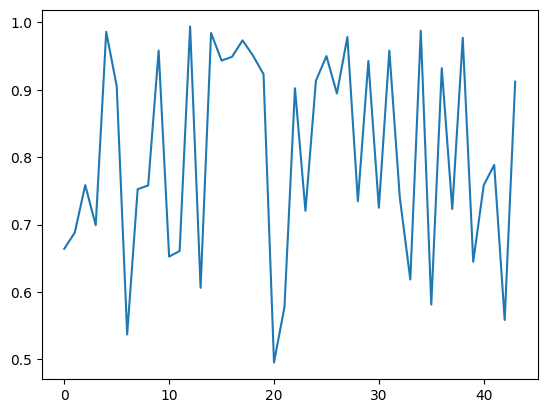

In [17]:
plt.plot(accuracy_scores)

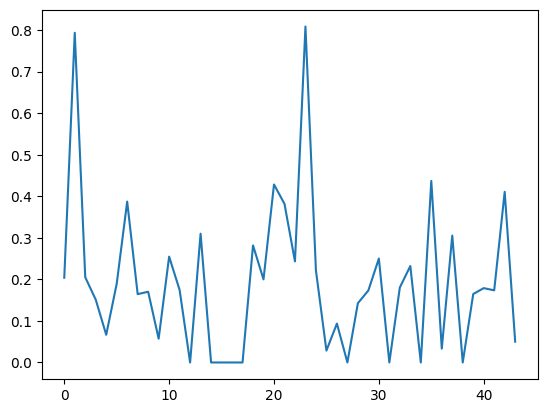

In [18]:
plt.plot(recall_scores)

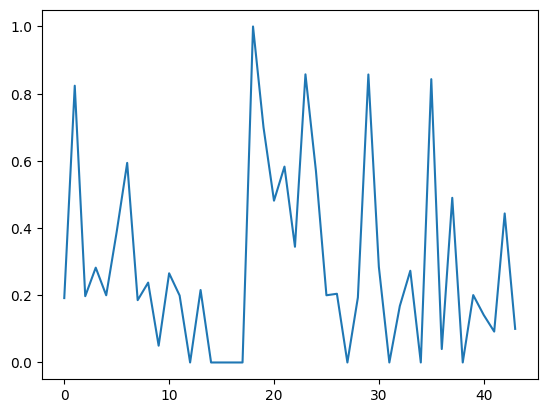

In [19]:
plt.plot(precision_scores)

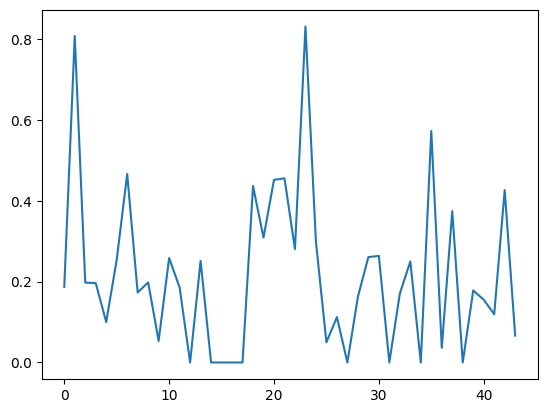

In [20]:
plt.plot(f1_scores)

In [29]:
clf = model

In [30]:
from joblib import dump, load
dump(clf, 'model.joblib') 

['model.joblib']